In [2]:
import numpy as np
import healpy as hp
import pandas as pd

import matplotlib.pyplot as plt

from astropy.io import fits

from shapely.ops import unary_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch

from skipper import observe
import sys
sys.path.append('/Users/shanydanieli/research/soft/skipper/scripts') 
import our_pointings

### Import databases

In [5]:
local_data_dir = '/Users/shanydanieli/projects/merian/decam_observing/datalogs/'

# get all potential pointings 
hcat_fall, ocat_fall = our_pointings.load_fallfields ()
hcat_spring, ocat_spring = our_pointings.load_springfields ()

# copilot database -- what we already observed
db_merain_filename = 'db_merian.fits'
copilot_db = fits.getdata(local_data_dir + db_merain_filename)


### Define the t_eff threshold for the two filters

In [70]:
# define what the t_eff threshold for both filters
min_teff_halpha = 600
min_teff_oiii = 850

### Read pointings that we already observed -- Spring + Fall, in both filters

In [119]:
# Spring H-alpha
coo_h_spring = observe.CopilotOutput(local_data_dir + db_merain_filename, hcat_spring, skySB_0=21.0)
coo_h_spring_reobserve = coo_h_spring.flag_for_reobservation(min_teff=min_teff_halpha)
coo_h_spring_observed = coo_h_spring.get_observed_catalog(min_teff=min_teff_halpha)
ra_h_spring = coo_h_spring.merian_sidecar['racenter'].to_numpy()
dec_h_spring = coo_h_spring.merian_sidecar['deccenter'].to_numpy()

# Spring, OIII
coo_o_spring = observe.CopilotOutput(local_data_dir+db_merain_filename, ocat_spring, skySB_0=22.1)
coo_o_spring_reobserve = coo_o_spring.flag_for_reobservation(min_teff=min_teff_oiii)
coo_o_spring_observed = coo_o_spring.get_observed_catalog(min_teff=min_teff_oiii)
ra_o_spring = coo_o_spring.merian_sidecar['racenter'].to_numpy()
dec_o_spring = coo_o_spring.merian_sidecar['deccenter'].to_numpy()

# Fall H-alpha
coo_h_fall = observe.CopilotOutput(local_data_dir+db_merain_filename, hcat_fall, skySB_0=21.0)
coo_h_fall_reobserve = coo_h_fall.flag_for_reobservation(min_teff=min_teff_halpha)
coo_h_fall_observed = coo_h_fall.get_observed_catalog(min_teff=min_teff_halpha)
ra_h_fall = coo_h_fall.merian_sidecar['racenter'].to_numpy()
ra_h_fall = [x-360 if x>300 else x for x in ra_h_fall]
dec_h_fall = coo_h_fall.merian_sidecar['deccenter'].to_numpy()

# Fall OIII
coo_o_fall = observe.CopilotOutput(local_data_dir+db_merain_filename, ocat_fall, skySB_0=22.1)
coo_o_fall_reobserve = coo_o_fall.flag_for_reobservation(min_teff=300)
coo_o_fall_observed = coo_o_fall.get_observed_catalog(min_teff=300)
ra_o_fall = coo_o_fall.merian_sidecar['racenter'].to_numpy()
ra_o_fall = [x-360 if x>300 else x for x in ra_o_fall]
dec_o_fall = coo_o_fall.merian_sidecar['deccenter'].to_numpy()


### Print out the progress report

In [72]:
# calculate how many pointings were observed in H-alpha in the Spring
n_h_spring = len(coo_h_spring_observed['object'])
n_o_spring = len(coo_o_spring_observed['object'])
n_h_fall = len(coo_h_fall_observed['object'])
n_o_fall = len(coo_h_fall_observed['object'])

# calc how many pointings are cosmos deep
n_h_cosmos_deep = len(coo_h_spring_observed[coo_h_spring_observed['object'].apply(lambda x: 'COSMOS' in x)]['object'])
n_o_cosmos_deep = len(coo_o_spring_observed[coo_o_spring_observed['object'].apply(lambda x: 'COSMOS' in x)]['object'])

total_cosmos_deep_point = n_h_cosmos_deep + n_o_cosmos_deep
total_point = n_h_spring + n_o_spring + n_h_fall + n_o_fall


# the total number of pointings to cover an area of 867 sq. deg.
total_point_need = 2*4*867./3.18 # 2 filters x 4 visits pointing x total area / area of one pointing

# calc the survey progress in terms of # of pointings observed
print('So far, ' + str(total_point)+ ' pointings were observed out of ' +str(round(total_point_need)) + ' needed')
print('That is, we observed ' + str(round(100*(total_point-total_cosmos_deep_point)/total_point_need,2))+ '% of the required pointings' )


So far, 542 pointings were observed out of 2181 needed
That is, we observed 22.6% of the required pointings


## Plot survey progress maps

### Spring, H-alpha

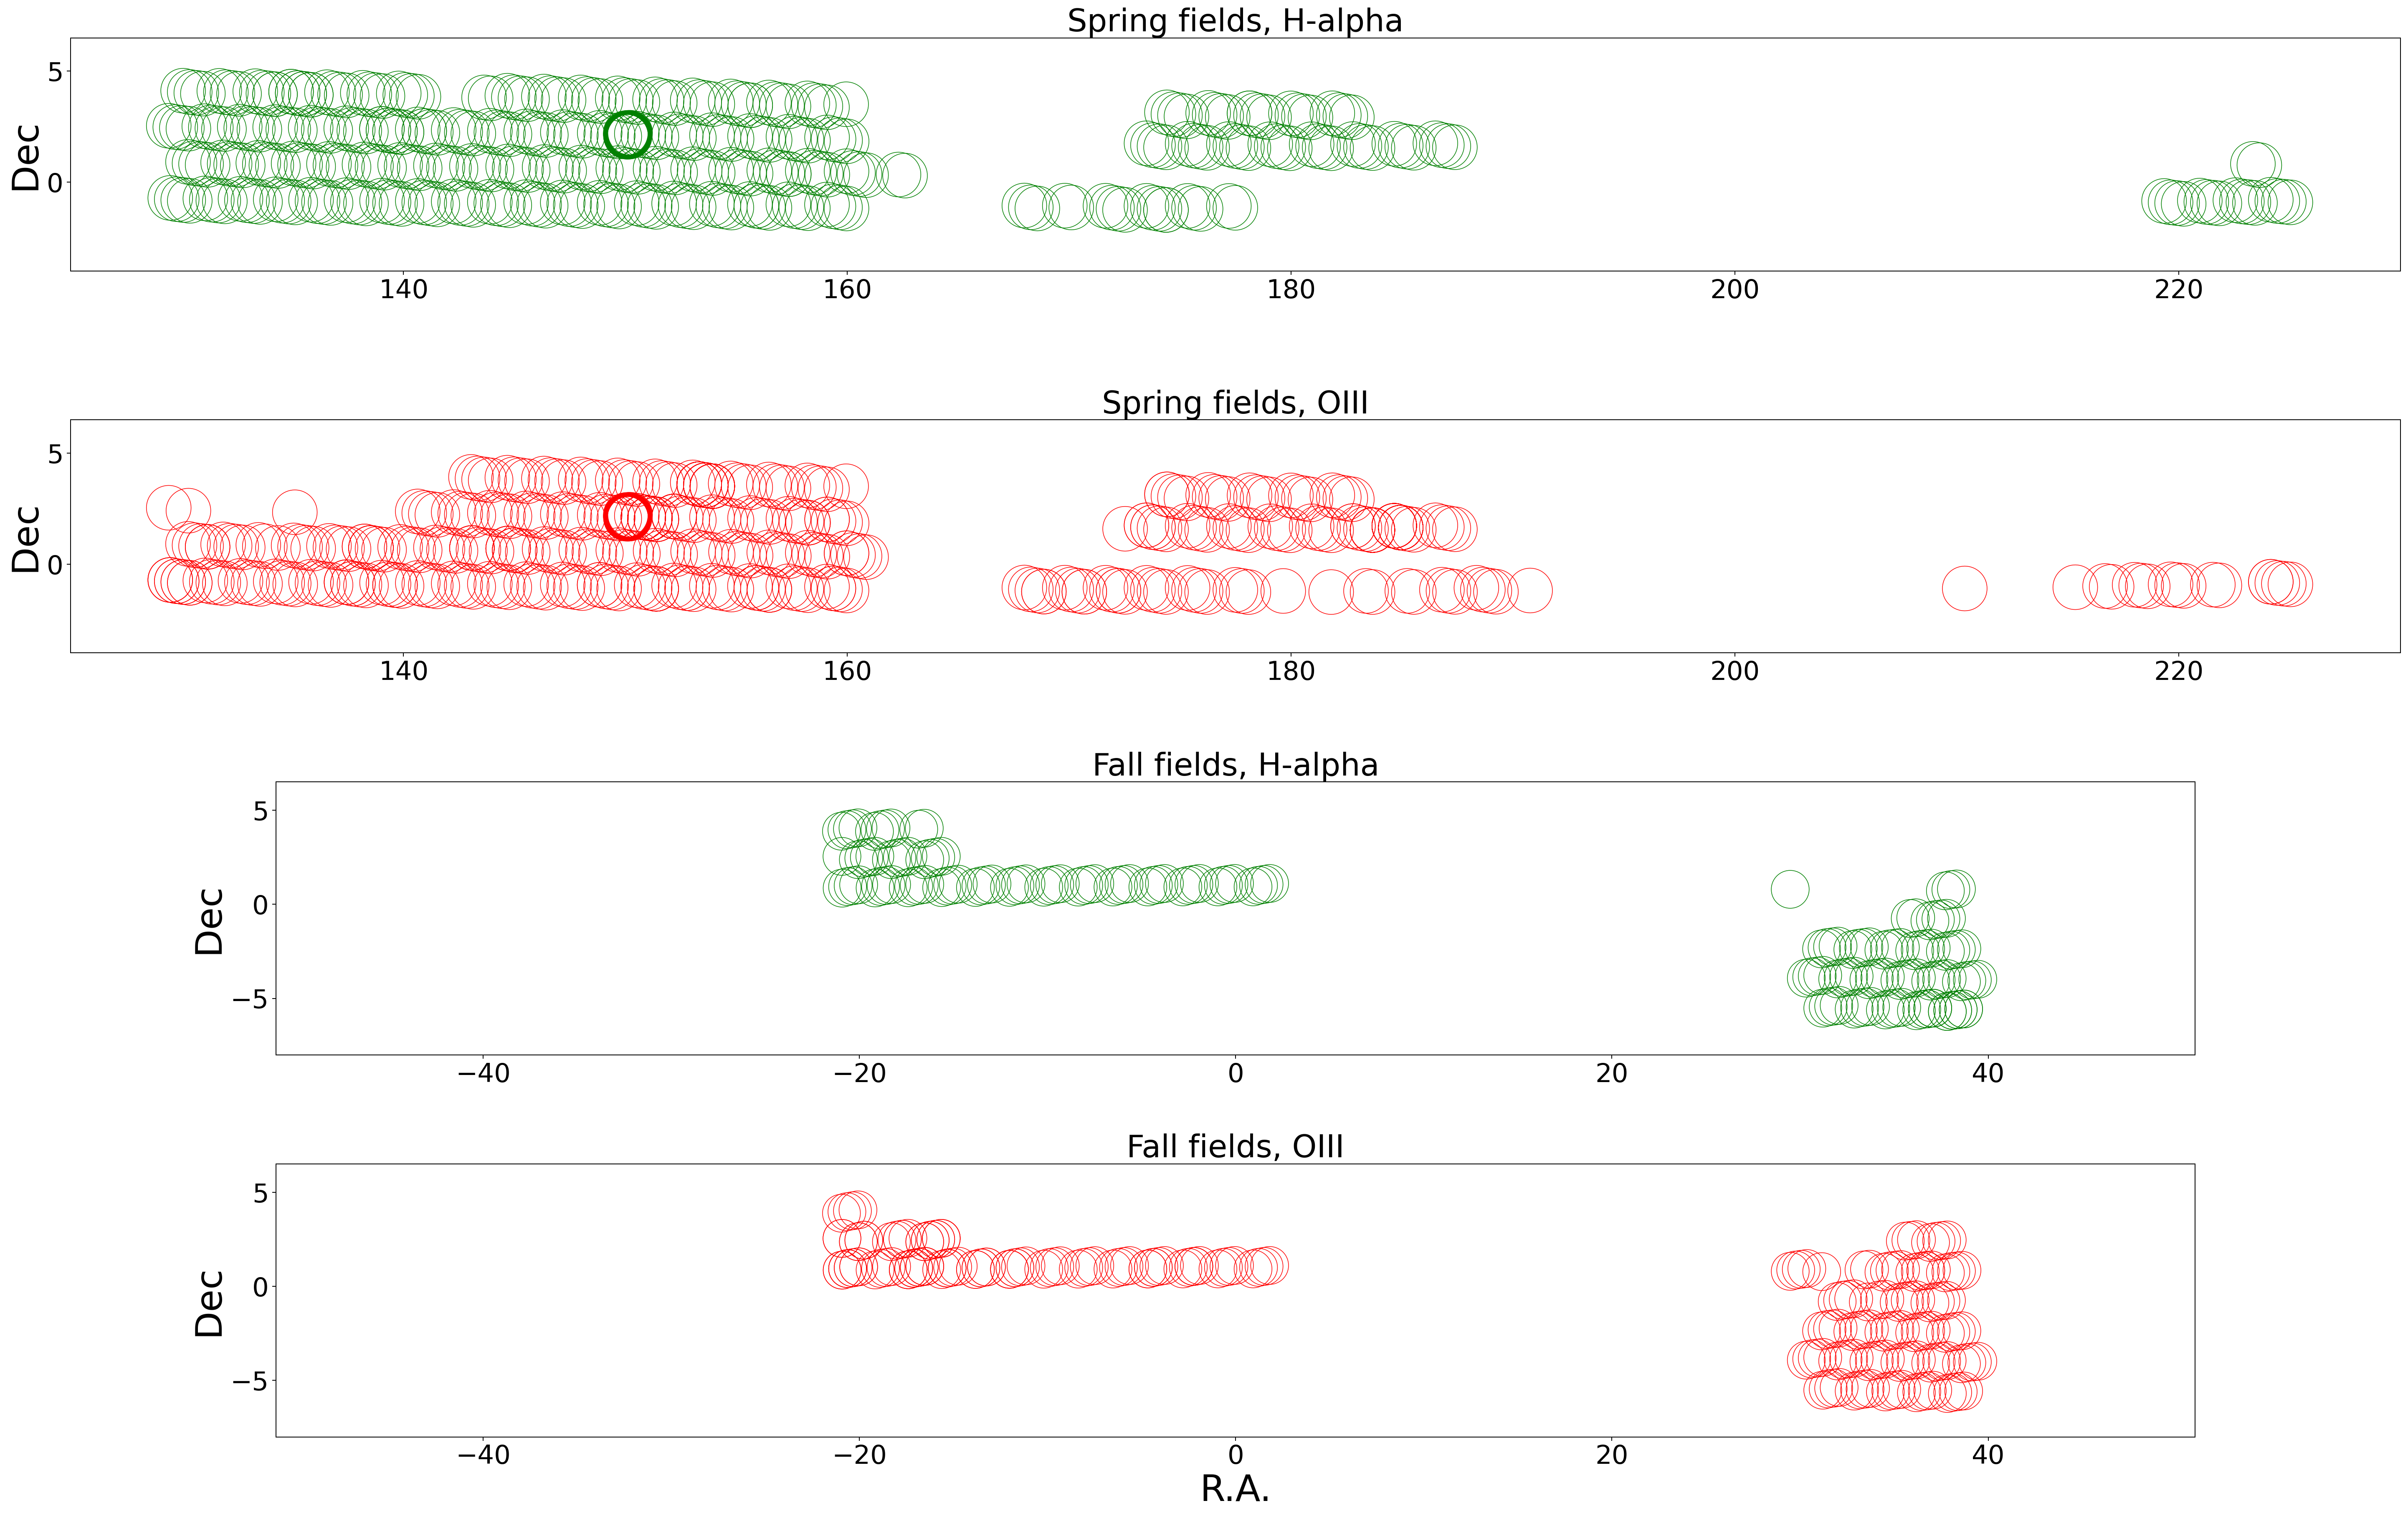

In [132]:
# the 3.18 fov is from here: https://iopscience.iop.org/article/10.3847/1538-3881/ab93b9/pdf
circle_radius = (3.18/np.pi)**0.5

# make circles with circle_radius radius
coo_h_spring_circles = [Point(ra_h_spring[i],dec_h_spring[i]).buffer(circle_radius) for i in range(len(dec_h_spring))]
coo_o_spring_circles = [Point(ra_o_spring[i],dec_o_spring[i]).buffer(circle_radius) for i in range(len(dec_o_spring))]
coo_h_fall_circles = [Point(ra_h_fall[i],dec_h_fall[i]).buffer(circle_radius) for i in range(len(dec_h_fall))]
coo_o_fall_circles = [Point(ra_o_fall[i],dec_o_fall[i]).buffer(circle_radius) for i in range(len(dec_o_fall))]


fig, (ax11, ax12, ax13, ax14) = plt.subplots(4,1, figsize=(40, 25), dpi=180)
# ax11 = fig.add_subplot(111, aspect='equal')
ax11.set_aspect('equal')
ax12.set_aspect('equal')
ax13.set_aspect('equal')
ax14.set_aspect('equal')

for i in range(len(coo_h_spring_circles)):
    patch = PolygonPatch(coo_h_spring_circles[i],lw=0.6,facecolor='none',edgecolor='green')
    ax11.add_patch(patch)
ax11.set_xlim(125,230)
ax11.set_ylim(-4,6.5)  

for i in range(len(coo_o_spring_circles)):
    patch = PolygonPatch(coo_o_spring_circles[i],lw=0.6,facecolor='none',edgecolor='red')
    ax12.add_patch(patch)
ax12.set_xlim(125,230)
ax12.set_ylim(-4,6.5)  

for i in range(len(coo_h_fall_circles)):
    patch = PolygonPatch(coo_h_fall_circles[i],lw=0.6,facecolor='none',edgecolor='green')
    ax13.add_patch(patch)
ax13.set_xlim(-51,51)
ax13.set_ylim(-8,6.5)  

for i in range(len(coo_o_fall_circles)):
    patch = PolygonPatch(coo_o_fall_circles[i],lw=0.6,facecolor='none',edgecolor='red')
    ax14.add_patch(patch)
ax14.set_xlim(-51,51)
ax14.set_ylim(-8,6.5)  


ax14.set_xlabel('R.A.', fontsize=35)
ax11.set_ylabel('Dec', fontsize=35)
ax12.set_ylabel('Dec', fontsize=35)
ax13.set_ylabel('Dec', fontsize=35)
ax14.set_ylabel('Dec', fontsize=35)
ax11.tick_params(axis='both', which='major', labelsize=25)
ax12.tick_params(axis='both', which='major', labelsize=25)
ax13.tick_params(axis='both', which='major', labelsize=25)
ax14.tick_params(axis='both', which='major', labelsize=25)
ax11.set_title('Spring fields, H-alpha', fontsize=30)
ax12.set_title('Spring fields, OIII', fontsize=30)
ax13.set_title('Fall fields, H-alpha', fontsize=30)
ax14.set_title('Fall fields, OIII', fontsize=30)

fig.subplots_adjust(hspace=0.4)

plt.savefig('/Users/shanydanieli/Desktop/merian_survey_map.jpeg',  bbox_inches='tight')